In [1]:
#importing all the necessary libraries.
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
#importing the initial data from the file "Mallards_initial data.xlsx"
mallards=pd.read_excel("Mallards_initial data.xlsx")
#The line bellow is used for debugging.
mallards = mallards.loc[:, ~mallards.columns.str.contains('^Unnamed')]
print(mallards.tail(5))

       population  farmed       date       hour  slatitude  slongitude
19910         111       0 2012-10-03   18:46:46  56.440178   13.992034
19911         111       0 2012-10-03   19:46:42  56.439957   13.992407
19912         111       0 2012-10-03   20:47:04  56.440022   13.992071
19913         111       0 2012-10-03   21:49:33  56.440029   13.992332
19914         111       0 2012-10-03   22:48:59  56.440067   13.993050


In [3]:
# instead of any other type of grouping we choose to group the mallards by ordering them by population.
ordered = mallards.sort_values(by=["population"]).reset_index(drop=True)

In [4]:
ordered.tail(10)

,population,farmed,date,hour,slatitude,slongitude
19905,153,1,2012-10-19,04:39:28,56.500893,13.970902
19906,153,1,2012-10-19,05:39:21,56.500786,13.970841
19907,153,1,2012-10-19,06:38:23,56.500889,13.971055
19908,153,1,2012-10-19,07:38:58,56.487541,13.965097
19909,153,1,2012-10-19,08:39:03,56.487274,13.965044
19910,153,1,2012-10-19,09:39:15,56.487392,13.965101
19911,153,1,2012-10-19,10:38:33,56.487503,13.965265
19912,153,1,2012-10-19,11:38:27,56.487041,13.965001
19913,153,1,2012-10-18,07:41:34,56.487537,13.965165
19914,153,1,2012-10-08,07:59:45,56.432728,13.989956


In [5]:
#Saving the ordered by population data into the Excel file "mallards_ordered.xlsx"
ordered.to_excel("mallards_ordered.xlsx", index=False)

In [6]:
#Creating the dataframe that is going to be used as y. Each column will be used as y in a different model.
labelled = pd.DataFrame(columns=["dlatitude", "dlongitude"])

#Generating the labels by making the next coordinates as the destination coordinates for the previous row.
for i, row in ordered.iterrows():
    if i == ordered.index[-1]:
        break
    if row["population"] != ordered.iloc[i+1]["population"]:
        label_row = pd.DataFrame({"dlatitude": row["slatitude"], "dlongitude": row["slongitude"]}, index=[i])
    else:
        label_row = pd.DataFrame({"dlatitude": ordered.iloc[i+1]["slatitude"], "dlongitude": ordered.iloc[i+1]["slongitude"]}, index=[i])
    labelled = pd.concat([labelled, label_row])


In [7]:
labelled.head(10)

,dlatitude,dlongitude
0,56.439716,13.991791
1,56.440170,13.992670
2,56.440136,13.992191
3,56.441143,13.988527
4,56.439919,13.991972
5,56.439869,13.992161
6,56.439716,13.992242
7,56.439934,13.991963
8,56.439888,13.992043
9,56.440109,13.991787


In [8]:
# drop last two rows from ordered dataframe. It is used for data management.
ordered = ordered.iloc[:-2].reset_index(drop=True)

# drop last row from labelled dataframe. It is used for data management.
labelled = labelled.iloc[:-1].reset_index(drop=True)

In [9]:
print(ordered.iloc[:-1].shape)

(19912, 6)


In [10]:
print(labelled["dlatitude"].iloc[:-1].shape)

(19912,)


In [11]:
# Making different splits for different models, one for longitude and one latitude.
X_train, X_test, y_lat_train, y_lat_test = train_test_split(
    ordered.iloc[:-1], labelled["dlatitude"].iloc[:-1], test_size=0.2, random_state=42
)
X_train, X_test, y_long_train, y_long_test = train_test_split(
    ordered.iloc[:-1], labelled["dlongitude"].iloc[:-1], test_size=0.2, random_state=42
)

In [12]:
X_train.shape

(15929, 6)

In [13]:
# We use standard scaler to do our scalling, instead of manual scaling.
scaler = StandardScaler()

In [14]:
# Making sure that date and hour have the necessary format.
X_train_no_date = X_train.drop(['date', 'hour'], axis=1)
X_train_scaled = scaler.fit_transform(X_train_no_date)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_no_date.columns, index=X_train_no_date.index)
X_train_scaled_df[['date', 'hour']] = X_train[['date', 'hour']]

In [15]:
# Making sure that date and hour have the necessary format.
X_test_no_date = X_test.drop(['date', 'hour'], axis=1)
X_test_scaled = scaler.transform(X_test_no_date)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_no_date.columns, index=X_test_no_date.index)
X_test_scaled_df[['date', 'hour']] = X_test[['date', 'hour']]

In [16]:
# extract day of the week and hour of the day from datetime columns
X_train_scaled_df['weekday'] = X_train_scaled_df['date'].dt.weekday
X_train_scaled_df['hour'] = pd.to_datetime(X_train_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_train_scaled_df['hour'] = X_train_scaled_df['hour'].dt.hour

X_test_scaled_df['weekday'] = X_test_scaled_df['date'].dt.weekday
X_test_scaled_df['hour'] = pd.to_datetime(X_test_scaled_df['hour'].str.strip(), format='%H:%M:%S')
X_test_scaled_df['hour'] = X_test_scaled_df['hour'].dt.hour

# drop the original datetime columns
X_train_scaled_df = X_train_scaled_df.drop(['date'], axis=1)
X_test_scaled_df = X_test_scaled_df.drop(['date'], axis=1)

In [17]:
X_train_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
11284,0.030042,-0.524242,0.125260,0.133639,21,5
11964,0.138355,-0.524242,0.127363,0.126657,19,0
5390,-0.879784,-0.524242,0.125449,0.134608,15,4
860,-1.356359,-0.524242,0.124414,0.135708,18,2
15795,0.939869,-0.524242,0.125983,0.133088,3,0


In [18]:
X_test_scaled_df.tail(5)

,population,farmed,slatitude,slongitude,hour,weekday
16564,1.113169,1.907515,0.123946,0.131636,21,4
19327,1.849695,1.907515,-4.781471,-1.732344,10,0
15022,0.874881,-0.524242,0.126517,0.128668,0,3
2457,-1.139734,-0.524242,0.124135,0.135700,5,1
9210,-0.229908,-0.524242,0.121909,0.135181,17,5


In [19]:
#Important part of the code. it is the place where we set our configuration.
n_units = 32
activation = 'linear'
loss_function = 'mean_squared_error'

In [20]:
# A separate model to detect latitude.
modelLat = Sequential()
modelLat.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLat.add(Dense(1))
modelLat.compile(optimizer='adam', loss=loss_function)

In [21]:
# A separate model to detect longitude.
modelLong = Sequential()
modelLong.add(Dense(n_units, activation=activation, input_shape=(X_train_scaled_df.shape[1],)))
modelLong.add(Dense(1))
modelLong.compile(optimizer='adam', loss=loss_function)

In [22]:
print(X_train_scaled_df.values.shape)

(15929, 6)


In [23]:
print(y_lat_train.values.shape)

(15929,)


In [24]:
print(modelLat.input_shape)

(None, 6)


In [25]:
X_train_scaled_df.shape

(15929, 6)

In [26]:
X_test_scaled_df.shape

(3983, 6)

In [27]:
# Fitting the data in the model for latitude.
historyLat=modelLat.fit(X_train_scaled_df.values, y_lat_train, validation_data=(X_test_scaled_df.values, y_lat_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 1s 2ms/step - loss: 1017.5850 - val_loss: 499.2830
Epoch 2/1000
498/498 [==============================] - 1s 2ms/step - loss: 426.9607 - val_loss: 359.3190
Epoch 3/1000
498/498 [==============================] - 1s 2ms/step - loss: 307.2889 - val_loss: 241.5629
Epoch 4/1000
498/498 [==============================] - 1s 2ms/step - loss: 173.8188 - val_loss: 103.5061
Epoch 5/1000
498/498 [==============================] - 1s 2ms/step - loss: 55.3606 - val_loss: 19.5268
Epoch 6/1000
498/498 [==============================] - 1s 2ms/step - loss: 7.3839 - val_loss: 1.2291
Epoch 7/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.3373 - val_loss: 0.0238
Epoch 8/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 8.4183e-04
Epoch 9/1000
498/498 [==============================] - 1s 2ms/step - loss: 9.8329e-04 - val_loss: 7.0356e-04 0s - loss
Epoch 10/1000
498/498 [==================

498/498 [==============================] - 1s 3ms/step - loss: 0.0044 - val_loss: 9.1974e-04: 0s - loss: 
Epoch 78/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0052 - ETA: 0s - lo
Epoch 79/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 80/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 7.6632e-04
Epoch 81/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 82/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 83/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 84/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0067
Epoch 85/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0026 - val_loss: 9.3134e-04
Epoch 86/1000
498/498 [========================

498/498 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 8.8633e-04
Epoch 155/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 156/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 157/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 158/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0054 - val_loss: 0.0258
Epoch 159/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 160/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 161/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 0.0012
Epoch 162/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0060
Epoch 163/1000
498/498 [==============================] - 1s 1ms/step - los

Epoch 231/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 232/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0085 - val_loss: 8.1701e-04
Epoch 233/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 234/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 235/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 236/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0106
Epoch 237/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0044 - val_loss: 8.7635e-04
Epoch 238/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 239/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0074 - val_loss: 7.9973e-04
Epoch 240/1000
498/498 [============================

498/498 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 309/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0027
Epoch 310/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0044
Epoch 311/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 8.8736e-04
Epoch 312/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 8.2707e-04
Epoch 313/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 7.9902e-04
Epoch 314/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 9.1259e-04
Epoch 315/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 316/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0028ETA: 0s - loss: 0.00
Epoch 317/1000
498/498 [===================

498/498 [==============================] - 1s 2ms/step - loss: 0.0025 - val_loss: 8.7649e-04
Epoch 385/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0047
Epoch 386/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 387/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 8.8893e-04
Epoch 388/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 7.8153e-04
Epoch 389/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 8.9440e-04
Epoch 390/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 391/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 392/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 393/1000
498/498 [==============================] - 1s 2m

498/498 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 0.0028
Epoch 462/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 463/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 464/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 465/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 466/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0067 - val_loss: 8.8500e-04
Epoch 467/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 468/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0043
Epoch 469/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 470/1000
498/498 [==============================] - 1s 2ms/step - los

Epoch 539/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0033 - val_loss: 8.7001e-04
Epoch 540/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 8.7221e-04
Epoch 541/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 542/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 543/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 8.6275e-04
Epoch 544/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 9.7863e-04
Epoch 545/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 9.2924e-04
Epoch 546/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 0.0054
Epoch 547/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 548/1000
498/498 [====================

498/498 [==============================] - 1s 2ms/step - loss: 0.0020 - val_loss: 0.0035
Epoch 617/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0052
Epoch 618/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 619/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 620/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0018
Epoch 621/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0025 - val_loss: 8.3900e-04
Epoch 622/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 623/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 624/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 625/1000
498/498 [==============================] - 1s 1ms/step - los

498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 695/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 696/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0055
Epoch 697/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0081 - val_loss: 0.0012
Epoch 698/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0021 - val_loss: 8.3907e-04
Epoch 699/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0064
Epoch 700/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 701/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 7.3958e-04
Epoch 702/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0032 - val_loss: 0.0345
Epoch 703/1000
498/498 [==============================] - 1s 1ms/step -

498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 9.0296e-04
Epoch 772/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0023 - val_loss: 7.8752e-04
Epoch 773/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0036 - val_loss: 0.0021
Epoch 774/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 775/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 776/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 777/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0101
Epoch 778/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 8.7833e-04
Epoch 779/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 780/1000
498/498 [==============================] - 1s 2ms/st

498/498 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 849/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0040 - val_loss: 0.0028
Epoch 850/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0029 - val_loss: 0.0101
Epoch 851/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 8.2806e-04
Epoch 852/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0030 - val_loss: 0.0044
Epoch 853/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0041
Epoch 854/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0038 - val_loss: 0.0104
Epoch 855/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 0.0188
Epoch 856/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0036 - val_loss: 0.0074
Epoch 857/1000
498/498 [==============================] - 1s 1ms/step - los

498/498 [==============================] - 1s 2ms/step - loss: 0.0026 - val_loss: 8.4700e-04
Epoch 927/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 928/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 7.5691e-04
Epoch 929/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 930/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0035 - val_loss: 8.6375e-04
Epoch 931/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 932/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0027 - val_loss: 0.0138
Epoch 933/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0077
Epoch 934/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 7.0629e-04
Epoch 935/1000
498/498 [==============================] - 1s 2m

In [28]:
# Fitting the data in the model for latitude.
historyLong=modelLong.fit(X_train_scaled_df.values, y_long_train, validation_data=(X_test_scaled_df.values, y_long_test), epochs=1000)

Epoch 1/1000
498/498 [==============================] - 1s 2ms/step - loss: 50.9376 - val_loss: 23.2766
Epoch 2/1000
498/498 [==============================] - 1s 1ms/step - loss: 18.1275 - val_loss: 12.3408
Epoch 3/1000
498/498 [==============================] - 1s 2ms/step - loss: 6.8242 - val_loss: 2.2524
Epoch 4/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.7002 - val_loss: 0.0580
Epoch 5/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0154 - val_loss: 0.0022
Epoch 6/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 7/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0021ETA: 0s - loss: 0.00
Epoch 8/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0044 - val_loss: 0.0018
Epoch 9/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 10/1000
498/498 [==============================] - 1

498/498 [==============================] - 1s 1ms/step - loss: 0.0062 - val_loss: 0.0020
Epoch 78/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0019
Epoch 79/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 80/1000
498/498 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0018
Epoch 81/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0071 - val_loss: 0.005805 - ETA: 0s - loss: 0.004 - ETA: 0s - lo
Epoch 82/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0064 - val_loss: 0.0023
Epoch 83/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0019
Epoch 84/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0406
Epoch 85/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0063 - val_loss: 0.0018
Epoch 86/1000
498/498 [=======================

498/498 [==============================] - 1s 3ms/step - loss: 0.0055 - val_loss: 0.0026
Epoch 155/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0110
Epoch 156/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 157/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 158/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0076
Epoch 159/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 160/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0060 - val_loss: 0.0018
Epoch 161/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0021
Epoch 162/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0059 - val_loss: 0.0019. - ETA: 0s - los
Epoch 163/1000
498/498 [==============================] - 1s 3

Epoch 232/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 233/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 234/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 235/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0059
Epoch 236/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0058 - val_loss: 0.0029
Epoch 237/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 238/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 239/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 240/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 241/1000
498/498 [==============================] - 1s 2ms

498/498 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0022
Epoch 310/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 311/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 312/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 313/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 314/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0023
Epoch 315/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0055 - val_loss: 0.0037.00 - ETA: 0
Epoch 316/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0053 - val_loss: 0.0021
Epoch 317/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0057 - val_loss: 0.0022
Epoch 318/1000
498/498 [==============================] - 1s 2ms/st

Epoch 387/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0019
Epoch 388/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0056 - val_loss: 0.0018 - ETA: 0s - loss: 0.0
Epoch 389/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 390/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 391/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 392/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0057 - val_loss: 0.0028
Epoch 393/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 394/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 395/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 396/1000
498/498 [==================

498/498 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 465/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 466/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0058 - val_loss: 0.0018- loss: 0.00
Epoch 467/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0049 - val_loss: 0.0028 - ETA: 0s 
Epoch 468/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 469/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0031
Epoch 470/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 471/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 472/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0093
Epoch 473/1000
498/498 [==============================] 

498/498 [==============================] - 1s 3ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 542/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 543/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 544/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 545/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 546/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 547/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0054 - val_loss: 0.0047
Epoch 548/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 549/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 550/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - ETA: 0s - loss: 0.004 - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 620/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.004305 - ETA: 0
Epoch 621/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 622/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0018
Epoch 623/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 624/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 625/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 626/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 627/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 628/1000
498/498 [====================

498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 697/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 698/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 699/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 700/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 701/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 702/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 703/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 704/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 705/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0021
Epoch 775/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 776/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 777/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 778/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 779/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 780/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 781/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 782/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0020
Epoch 783/1000
498/498 [==============================] - 1s 2ms/step - loss: 0

498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 853/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0027
Epoch 854/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 855/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 856/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 857/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0050 - val_loss: 0.0020
Epoch 858/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 859/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 860/1000
498/498 [==============================] - 1s 2ms/step - loss: 0.0043 - val_loss: 0.0164
Epoch 861/1000
498/498 [==============================] - 1s 3ms/step - loss: 0

498/498 [==============================] - 1s 3ms/step - loss: 0.0049 - val_loss: 0.0018
Epoch 931/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 932/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0047 - val_loss: 0.0019 0s - loss: 0
Epoch 933/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 934/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 935/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 936/1000
498/498 [==============================] - 2s 3ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 937/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 938/1000
498/498 [==============================] - 1s 3ms/step - loss: 0.0046 - val_loss: 0.0020 loss: 0.00
Epoch 939/1000
498/498 [==============================]

In [29]:
# Predict the Longitude values for the test set
y_long_pred = modelLong.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_long_test, y_long_pred)
rmse = mean_squared_error(y_long_test, y_long_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.01297647209360178
Root Mean Squared Error (RMSE): 0.04359648796918636


In [30]:
# Predict the Latitude values for the test set
y_lat_pred = modelLat.predict(X_test_scaled_df)

# Compute the mean absolute error and root mean squared error
mae = mean_absolute_error(y_lat_test, y_lat_pred)
rmse = mean_squared_error(y_lat_test, y_lat_pred, squared=False)

# Print the MAE and RMSE
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)

Mean Absolute Error (MAE): 0.0063822391833382635
Root Mean Squared Error (RMSE): 0.026846473065442404


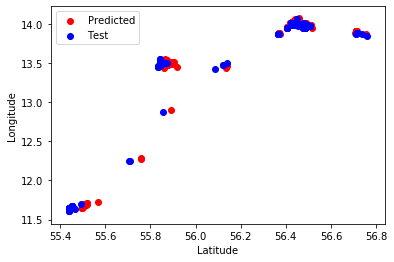

In [31]:
# create scatter plot
plt.scatter(y_lat_pred, y_long_pred, c='r', label='Predicted')
plt.scatter(y_lat_test, y_long_test, c='b', label='True')

# add labels and legend
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()

# show plot
plt.show()

In [32]:
X_test["population"].shape

(3983,)

In [33]:
y_lat_test_comb = pd.DataFrame(y_lat_test)
y_lat_test_comb.shape

(3983, 1)

In [34]:
y_long_test_comb = pd.DataFrame(y_long_test)
y_long_test_comb.shape

(3983, 1)

In [35]:
y_lat_pred_comb = pd.DataFrame(y_lat_pred)
y_lat_pred_comb.shape

(3983, 1)

In [36]:
y_long_pred_comb = pd.DataFrame(y_long_pred)
y_long_pred_comb.shape

(3983, 1)

In [37]:
pop_df = pd.DataFrame(X_test["population"].values.reshape(-1, 1))
pop_df.shape

(3983, 1)

In [38]:
# Create a dataframe with all the values, (predicted and actual), in order to be used for diagrams and comparisons.
combined_df = pd.concat([pop_df, y_lat_pred_comb, y_long_pred_comb, y_lat_test_comb, y_long_test_comb], axis=1)
combined_df.columns = ["population", "Pred_latitude", "Pred_longitude", "latitude", "longitude"]

In [39]:
combined_df = combined_df.dropna()

In [40]:
combined_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
0,71.0,56.440418,14.008556,56.439716,13.991791
3,88.0,56.441643,13.998838,56.441143,13.988527
6,131.0,56.440228,14.002150,56.439716,13.992242
17,27.0,56.443287,14.005896,56.439903,13.992476
19,23.0,56.446011,14.011674,56.439484,13.992446
31,67.0,56.447277,14.005354,56.439350,13.992638
34,24.0,56.448582,14.007319,56.440166,13.992716
35,131.0,56.443184,14.003843,56.439930,13.992993
41,152.0,56.437103,13.986850,56.440140,13.992735
42,152.0,56.452526,13.989434,56.440044,13.992678


In [41]:
#selecting the most frequent population of the populations that have more than 20 members.
threshold = 20
populations_above_threshold = combined_df['population'].value_counts()[combined_df['population'].value_counts() >= threshold].index
if len(populations_above_threshold) > 0:
    most_frequent_pop = combined_df.loc[combined_df['population'].isin(populations_above_threshold)]['population'].value_counts().idxmax()
    most_frequent_pop_df = combined_df.loc[combined_df['population'] == most_frequent_pop]
else:
    print("change the threshold!")


In [42]:
most_frequent_pop_df.head(50)

,population,Pred_latitude,Pred_longitude,latitude,longitude
41,152.0,56.437103,13.986850,56.440140,13.992735
42,152.0,56.452526,13.989434,56.440044,13.992678
181,152.0,56.438358,13.986460,56.440220,13.992155
218,152.0,56.435722,13.986401,56.440342,13.992517
257,152.0,56.135715,13.430973,56.439884,13.991575
449,152.0,56.406097,13.944263,56.439644,13.992051
466,152.0,56.447620,13.987988,56.439968,13.992618
836,152.0,56.440105,13.996031,56.439949,13.992587
1010,152.0,56.442257,13.986260,56.439953,13.993013
1063,152.0,56.443050,13.985336,56.439720,13.992579


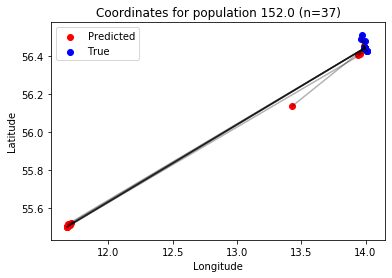

In [43]:
# Filter for rows with non-null predicted and true coordinates
filtered_df = most_frequent_pop_df.dropna(subset=['Pred_latitude', 'Pred_longitude', 'latitude', 'longitude'])

# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()


In [44]:
most_frequent_pop_df.shape

(37, 5)

In [45]:
# Removing outliers
filtered_df = filtered_df[(filtered_df['Pred_longitude'] >= 13.7) & (filtered_df['longitude'] >= 13.7)]

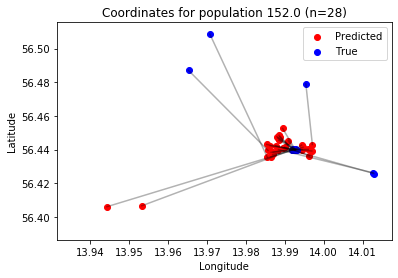

In [46]:
# Create scatter plot of predicted and true coordinates
plt.scatter(filtered_df['Pred_longitude'], filtered_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(filtered_df['longitude'], filtered_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in filtered_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for population {most_frequent_pop} (n={len(filtered_df)})")

# Show plot
plt.show()

In [47]:
# Removing outliers
combined_df = combined_df[(combined_df['Pred_longitude'] >= 13.7) & (combined_df['longitude'] >= 13.7)]

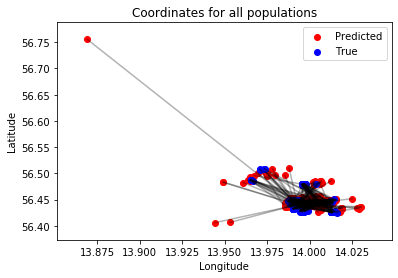

In [48]:
# Create scatter plot of predicted and true coordinates
plt.scatter(combined_df['Pred_longitude'], combined_df['Pred_latitude'], c='r', label='Predicted')
plt.scatter(combined_df['longitude'], combined_df['latitude'], c='b', label='True')

# Connect predicted and true coordinates with lines
for index, row in combined_df.iterrows():
    plt.plot([row['Pred_longitude'], row['longitude']], [row['Pred_latitude'], row['latitude']], 'k-', alpha=0.3)

# Add legend and labels
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Coordinates for all populations")

# Show plot
plt.show()